reproducing Figure 9.2 (n-step semi-gradient TD)


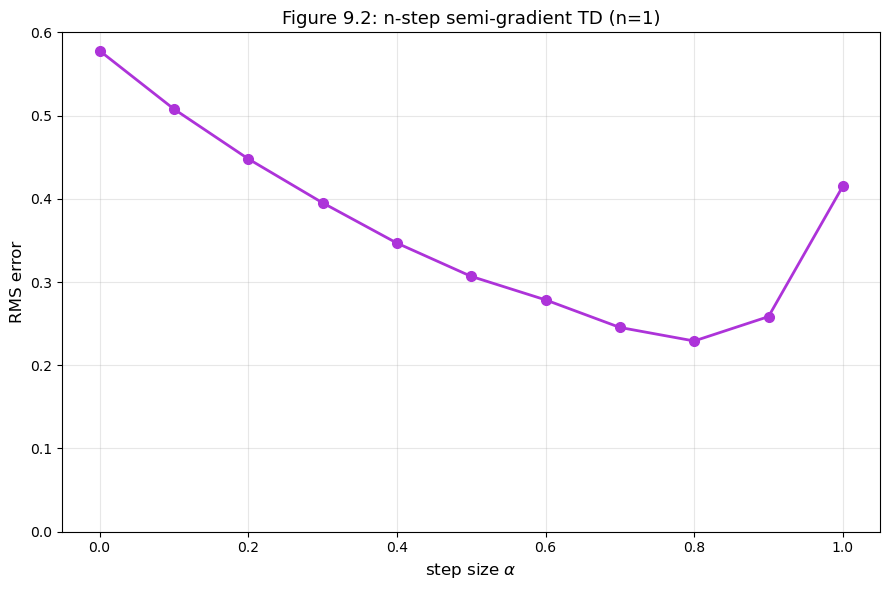

In [ ]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Figure 9.2 Linear Function Approximation 
# This is the code for the right graph of Figure 9.2 in Sutton and Barto's RL textbook, below this code block is the implementation of the left graph
# i used numpy for numerical operations and matplotlib for plotting

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#============================================================================
# ENVVIRONMENT
#============================================================================

class RandomWalk1000:
    """1000-state random walk task from Sutton Barto Chapter 9"""
    
    def __init__(self):
        self.start = 500
        self.reset() 
    

    def reset(self):
        self.state = self.start #sets state to start
        return self.state
    
    def is_terminal(self):
        return self.state <= 0 or self.state >= 1001 # boundary states are terminal
    
	
    def step(self, action=None):
        step_size = np.random.randint(1, 101) 
        direction = np.random.choice([-1, 1]) 
        
        self.state += direction * step_size # update state based on step size and direction
        
        if self.state <= 0: # left terminal state
            return 0, -1.0
        elif self.state >= 1001: # right terminal state
            return 1001, 1.0
        else: # non-terminal state
            return self.state, 0.0


# ============================================================================
# TD LEARNER AGENT
# ============================================================================

class TD_Agent:
    """n-step semi-gradient TD learner using state aggregation"""
    
    def __init__(self, num_weights, alpha, n_step): #initialize agent with number of weights, step size alpha, and n-step parameter
        self.w = np.zeros(num_weights) 
        self.alpha = alpha
        self.n_step = n_step
        self.num_groups = num_weights
        self.group_size = 1000 // num_weights
    
    def get_group(self, state): #map state to its corresponding group
        if state <= 0 or state >= 1001: 
            return None
        return (state - 1) // self.group_size 
    

    def estimate(self, state): # estimates the states value based on its group weight
        group = self.get_group(state)
        if group is None:
            return 0.0
        return self.w[group]
    

    def learn_episode(self, env): # learns from a single episode
        state = env.reset()
        trajectory = [state]
        rewards = []
        
        while not env.is_terminal(): # while episode not terminated
            next_state, reward = env.step() 
            trajectory.append(next_state) 
            rewards.append(reward)
            state = next_state 
        

        trajectory.append(env.state)
        episode_length = len(rewards)
        

        
        for t in range(episode_length):
            G = 0.0 
            
            for i in range(t, min(t + self.n_step, episode_length)): # accumulate rewards for n steps
                G += rewards[i]
            
            if t + self.n_step < episode_length: # if n-step goes beyond episode length
                next_state = trajectory[t + self.n_step] 
                G += self.estimate(next_state) # add estimated value of next state
            
            state_t = trajectory[t]
            current_estimate = self.estimate(state_t) 
            error = G - current_estimate # compute TD error
            
            group = self.get_group(state_t) 
            if group is not None: # update weight for the group
                self.w[group] += self.alpha * error 





def compute_true_values(): # compute true state values for all states
    v = np.zeros(1002)
    for s in range(1, 1001):
        v[s] = -1.0 + (s - 1) * (2.0 / 999.0)
    return v

def rms_error(agent, true_v): # compute root mean squared error between agent estimates and true values
    estimates = np.array([agent.estimate(s) for s in range(1, 1001)])
    targets = true_v[1:1001]
    mse = np.mean((estimates - targets) ** 2)
    return np.sqrt(mse)

# ============================================================================
# run experiment and plot results 
# ============================================================================



print("reproducing Figure 9.2 (n-step semi-gradient TD)")
print("=" * 60)

alphas = np.linspace(0.0, 1.0, 11)

n_step = 1
num_groups = 20
num_runs = 100
num_episodes = 10

true_v = compute_true_values()
results = []

for alpha in alphas: #comment out print statements when submitting
    #print(f"alpha = {alpha:.1f}", end=" ... ")
    

    total_error = 0.0
    
    # multiple runs for averaging
    for run in range(num_runs):
        agent = TD_Agent(num_groups, alpha, n_step)
        env = RandomWalk1000()
        
        for ep in range(num_episodes):
            agent.learn_episode(env)
        
        error = rms_error(agent, true_v)
        total_error += error
    
	# average over runs
    avg_error = total_error / num_runs
    results.append(avg_error)
    #print(f"avg rms error = {avg_error:.4f}")

# plot results
plt.figure(figsize=(9, 6))
plt.plot(alphas, results, 'o-', linewidth=2, markersize=7, color="#ad33d9")
plt.xlabel(r'step size $\alpha$', fontsize=12)
plt.ylabel('RMS error', fontsize=12)
plt.title('Figure 9.2: n-step semi-gradient TD (n=1)', fontsize=13)
plt.grid(True, alpha=0.3)
plt.ylim(0.0, 0.6)
plt.tight_layout()
plt.show()


reproducing Figure 9.1 (Gradient Monte Carlo)


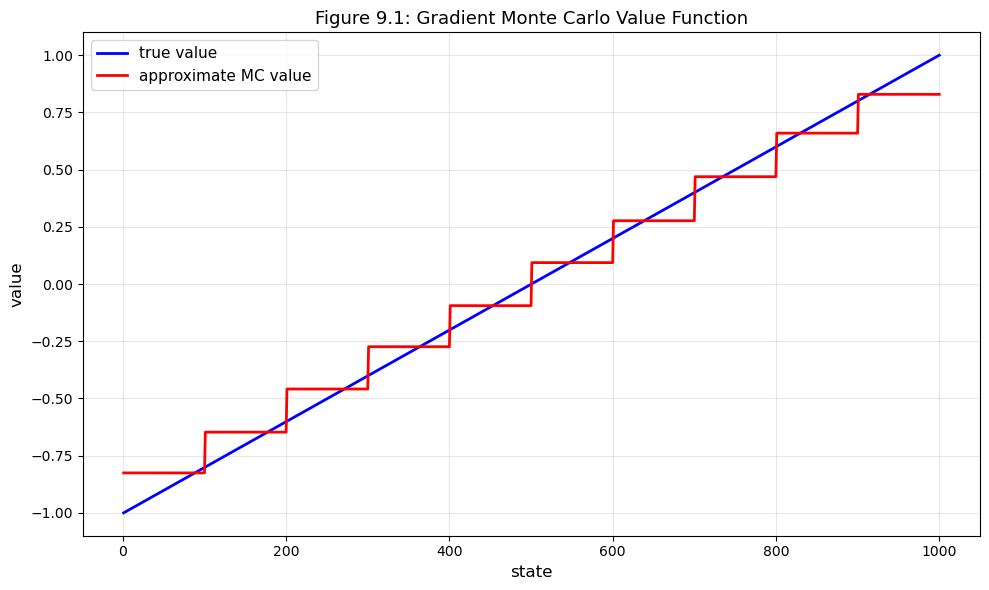

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
#  ENVIRONMENT (same as above)
# ============================================================================
class RandomWalk1000:
    """1000-state random walk task from Sutton Barto Chapter 9"""  
    def __init__(self):
        self.start = 500
        self.reset()
    
    def reset(self):
        self.state = self.start
        return self.state
    
    def is_terminal(self):
        return self.state <= 0 or self.state >= 1001
    
    def step(self, action=None):
        step_size = np.random.randint(1, 101) # random step size between 1 and 100
        direction = np.random.choice([-1, 1]) # random direction: left (-1) or right (+1)
        
        self.state += direction * step_size
        
        if self.state <= 0:
            return 0, -1.0
        elif self.state >= 1001: 
            return 1001, 1.0
        else:
            return self.state, 0.0

# ============================================================================
# GRADIENT MONTE CARLO AGENT
# ============================================================================

class MC_Agent:
    """gradient monte carlo learner using state aggregation"""
    
    def __init__(self, num_weights, alpha): #initialize agent with number of weights and step size alpha
        self.w = np.zeros(num_weights) 
        self.alpha = alpha
        self.num_groups = num_weights
        self.group_size = 1000 // num_weights
    
    def get_group(self, state): #map state to its corresponding group
        if state <= 0 or state >= 1001:
            return None
        return (state - 1) // self.group_size # map state to group index
    
    def estimate(self, state): # estimate state value based on its group weight
        group = self.get_group(state)
        if group is None:
            return 0.0
        return self.w[group]
    
    def learn_episode(self, env):
        """run one episode and update using MC return (G = actual cumulative reward)"""
        state = env.reset()
        trajectory = [state]
        rewards = []
        # collect full episode
        while not env.is_terminal():
            next_state, reward = env.step()
            trajectory.append(next_state)
            rewards.append(reward)
            state = next_state
        
        # compute MC return (G = sum of all rewards from start)
        # wehn gamma=1, this is just the total reward
        G = sum(rewards)
        
        # update each state in trajectory toward the same return G
        for state_t in trajectory[:-1]: 
            current_estimate = self.estimate(state_t)
            error = G - current_estimate
            
            group = self.get_group(state_t)
            if group is not None:
                self.w[group] += self.alpha * error


def compute_true_values(): # compute true state values for all states
    
    v = np.zeros(1002)
    for s in range(1, 1001):
        v[s] = -1.0 + (s - 1) * (2.0 / 999.0)
    return v

def rms_error(agent, true_v): # compute root mean squared error between agent estimates and true values
    
    estimates = np.array([agent.estimate(s) for s in range(1, 1001)])
    targets = true_v[1:1001]
    mse = np.mean((estimates - targets) ** 2)
    return np.sqrt(mse)


# ============================================================================
# run experiment and plot lefgt graph results
# ============================================================================

print("reproducing Figure 9.1 (Gradient Monte Carlo)")
print("=" * 60)

alpha = 2e-5 
num_groups = 10 
num_episodes = 100000

true_v = compute_true_values()
agent = MC_Agent(num_groups, alpha)
env = RandomWalk1000()

# run many episodes (comment out print statements when submitting)
for ep in range(num_episodes):
    agent.learn_episode(env)
    
    if (ep + 1) % 25000 == 0:
        error = rms_error(agent, true_v)
        #print(f"episode {ep + 1:6d}: rms error = {error:.4f}")

#print("=" * 60)

# get final learned values
learned_values = np.array([agent.estimate(s) for s in range(1, 1001)])
true_values_plot = true_v[1:1001]

# plot: learned vs true values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), true_values_plot, label='true value', linewidth=2, color='blue')
plt.plot(range(1, 1001), learned_values, label='approximate MC value', linewidth=2, color='red')
plt.xlabel('state', fontsize=12)
plt.ylabel('value', fontsize=12)
plt.title('Figure 9.1: Gradient Monte Carlo Value Function', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()